In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_tuner
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import numpy as np
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/__init__.py:104: UserWarning

# After model was obtained with param optimization, we need to train it: 

## 9. Evaluate it's performance by doing k-Fold Cross Validation and improve the weights from the model 
https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/ <br>
https://repository.tudelft.nl/islandora/object/uuid%3A6f4f3def-f8e0-4820-8b4f-75b0254dadcd <br>
https://stackoverflow.com/questions/50997928/typeerror-only-integer-scalar-arrays-can-be-converted-to-a-scalar-index-with-1d


Get the data 

In [3]:
# Data from the elephant listening project 
general_path = os.path.join('data', 'Clips')

# To ensure that both classes have same of samples and to increase the number of gunshots, 
# I extracted extra data from: https://data.mendeley.com/datasets/x48cwz364j/3 
background_path = os.path.join('data', 'Sounds_background')
guns_path = os.path.join('data', 'Sounds_gunshots')

gunshot_files = [os.path.join(general_path, 'pnnn*'), os.path.join(general_path, 'ecoguns*'), os.path.join(guns_path, '*\.wav')]

no_gunshot_files = [os.path.join(general_path, 'other*'), os.path.join(background_path, '*\.wav')] 
gunshot = tf.data.Dataset.list_files(gunshot_files) 
no_gunshot = tf.data.Dataset.list_files(no_gunshot_files) 


In [4]:
def load_data(file_name): 
    file_contents = tf.io.read_file(file_name) #retuns a string 
    wave, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # transforms string into actual wav
    wave = wave - tf.reduce_mean(wave) # remove the mean 
    wave = wave / tf.reduce_max(tf.abs(wave)) #normalize 
    wave = tf.squeeze(wave, axis= -1) #removes axis 
    #wave = tf.cast(wave * 32768, tf.float32) # value is scaled to look like int16, however, type is kept as float32 for compatibility issues

    return wave, sample_rate

In [5]:
def preprocess(file_path, label): 
    # Load data
    wave, sr = load_data(file_path)
    max_lenght = 80000 # = 10* 8000, this means 10 seconds 

    # Padding 
    wave = wave[:max_lenght] #grab first elements up to max(lengths)
    zero_padding = tf.zeros(max_lenght - tf.shape(wave), dtype=tf.float32) # pad with zeros what doesn't meet full length 
    wave = tf.concat([zero_padding, wave],0) 

    # Create spectogram 
    # 1. Fast fourier transform 
    spectrogram = tf.signal.stft(wave, frame_length=256, frame_step=128)  # Paper: 'Automated detection of gunshots in tropical forests using CNN' 
    # frame_length =  window length in samples
    # frame_step = number of samples to step
    # 'Time frequency compromise' 
    # if window size is small: you get good time resolution in exchange of poor frequency resolution 

    # 2. Obtain the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)

    # 3. Tranform it into appropiate format for deep learning model by adding the channel dimension (in this case 1)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label


In [6]:
gunshot = tf.data.Dataset.zip((gunshot, tf.data.Dataset.from_tensor_slices(tf.ones(len(gunshot)))))
no_gunshot= tf.data.Dataset.zip((no_gunshot, tf.data.Dataset.from_tensor_slices(tf.zeros(len(gunshot)))))
data = gunshot.concatenate(no_gunshot)
data = data.map(preprocess) # calling preprocess method which generates spectograms
data = data.cache()
data = data.shuffle(buffer_size=1000) # mixing training samples 1000 at the time  

In [7]:
iterator = data.as_numpy_iterator()
x = []
y = []
while True:
    try: 
        x_temp, y_temp = iterator.next()
        x.append(x_temp)
        y.append(y_temp)
    except Exception:
        break 

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.30, random_state=123)

2023-05-03 22:42:52.153445: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Fit model 

# Evaluate model 

In [ ]:
import model_performance
location = 'data/models/01'

confusion_matrices, histories = model_performance.performance(location)

# 8. Evaluate model performance 

In [15]:
# evaluate the model on a validation set
loss, accuracy = model.evaluate(np.stack(x_valid), np.stack(y_valid))

# print the evaluation results
print(f'Validation loss: {loss:.4f}')
print(f'Validation accuracy: {accuracy:.4f}')

34/34 [==============================] - 4s 81ms/step - loss: 3.9146e-05 - accuracy: 1.0000
Validation loss: 0.0000
Validation accuracy: 1.0000


## 10. Confusion Matrix 
https://www.tensorflow.org/tutorials/audio/simple_audio

In [11]:
mean_matrix = np.mean(confusion_matrices, axis=0)

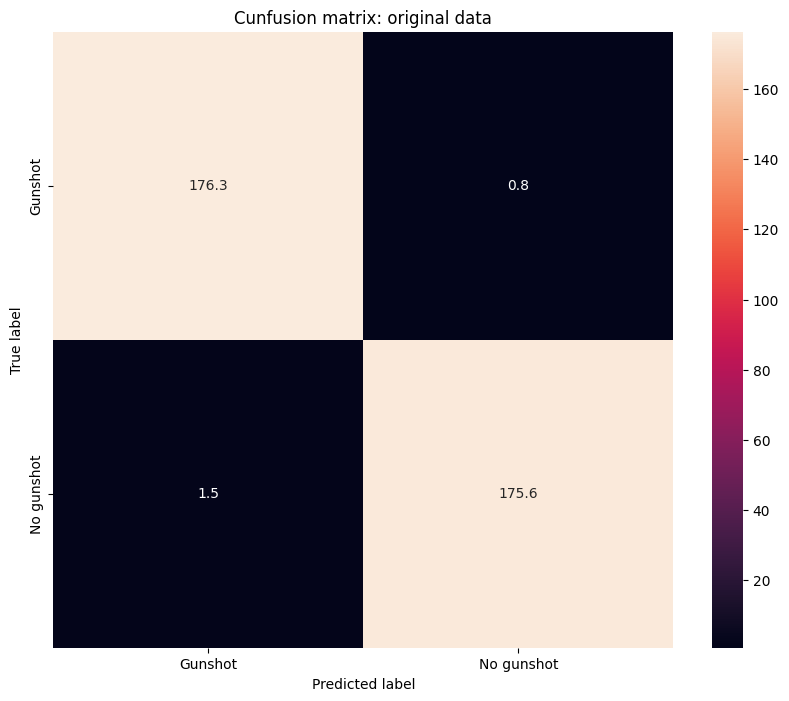

In [12]:
label_names = ['Gunshot' ,'No gunshot']
plt.figure(figsize=(10, 8))
sns.heatmap(mean_matrix,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Cunfusion matrix: original data')
plt.savefig('confusion_matrix_original_data.png')
plt.show()


## 11. Display and save graphs of other metrics

Obtain the mean of all different k-folds 

In [49]:
histories[0].history # first model 


{'loss': [8.909273674362339e-06,
  1.3093682355247438e-05,
  7.15720261723618e-06,
  8.998566954687703e-06,
  9.239744031219743e-06],
 'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [2.4934990506153554e-05,
  2.509884870960377e-05,
  2.518311703170184e-05,
  2.514016887289472e-05,
  2.5050301701412536e-05],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0]}

In [ ]:
list_loss = []
list_val_loss = []

list_accuracy = []
list_val_accuracy = []

for i in range(epoch):
    print (i)
    temp_loss = []
    temp_val_loss = []
    for his in histories: 
        if i < len(hist.history['loss']): #exists 
            temp_loss.append(hist.history['loss'][i]) # grab the same epoch across all different models 
            temp_val_loss.append(hist.history['val_loss'][i])
    list_loss.append(np.mean(temp_loss))
    list_val_loss.append(np.mean(temp_val_loss))

for i in range(epoch):
    temp_accuracy = []
    temp_val_accuracy = []
    for his in histories: 
        if i < len(hist.history['accuracy']): #exists 
            temp_accuracy.append(hist.history['accuracy'][i]) # grab the same epoch across all different models 
            temp_val_accuracy.append(hist.history['val_accuracy'][i])
    list_accuracy.append(np.mean(temp_accuracy))
    list_val_accuracy.append(np.mean(temp_val_accuracy))



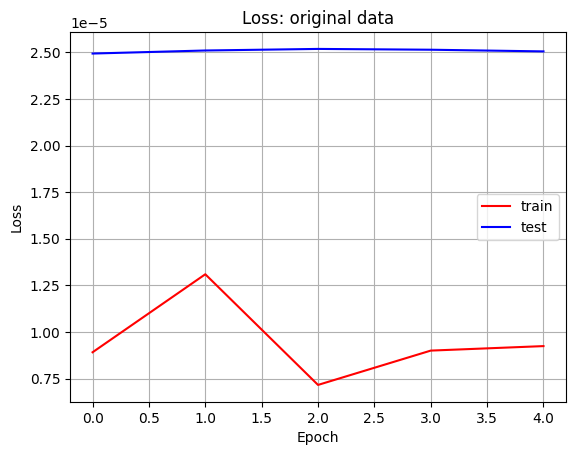

In [53]:
plt.title('Loss: original data')
plt.plot(list_loss, 'r')
plt.plot(list_val_loss, 'b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.grid()
#plt.savefig('loss_original_data.png')
plt.show()

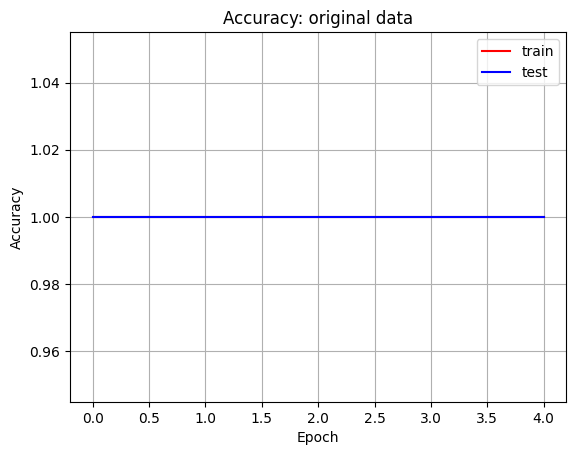

In [55]:
plt.title('Accuracy: original data')
plt.plot(list_accuracy, 'r')
plt.plot(list_val_accuracy, 'b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.grid()
#plt.savefig('accuracy_original_data.png')
plt.show()

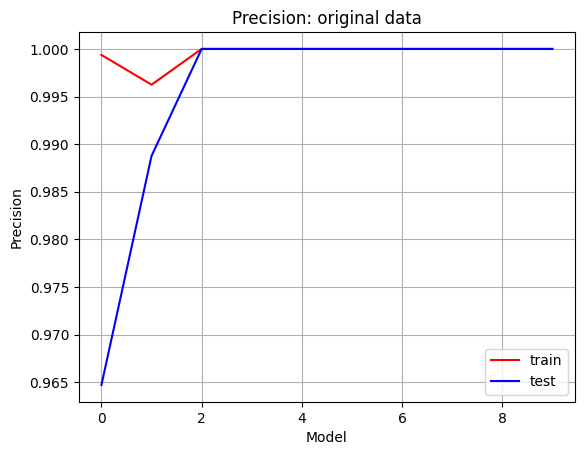

In [57]:
plt.title('Precision: original data')
plt.plot(precision_train, 'r')
plt.plot(precision_test, 'b')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.legend(['train', 'test'])
plt.grid()
#plt.savefig('accuracy_original_data.png')
plt.show()


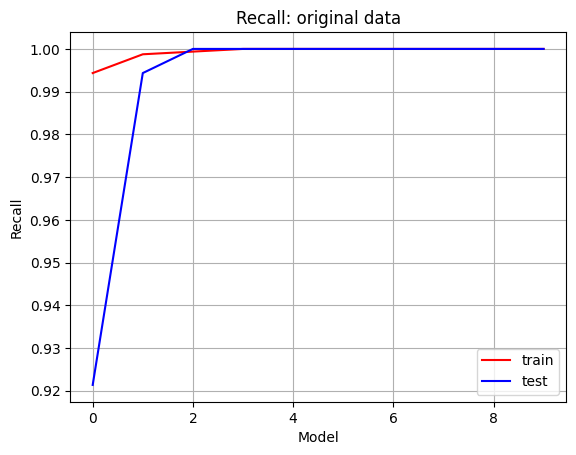

In [58]:
plt.title('Recall: original data')
plt.plot(recall_train, 'r')
plt.plot(recall_test, 'b')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.legend(['train', 'test'])
plt.grid()
#plt.savefig('accuracy_original_data.png')
plt.show()


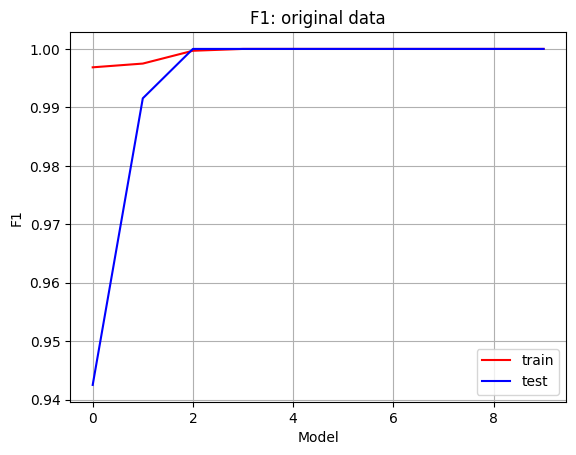

In [59]:
plt.title('F1: original data')
plt.plot(F1_train, 'r')
plt.plot(F1_test, 'b')
plt.xlabel('Model')
plt.ylabel('F1')
plt.legend(['train', 'test'])
plt.grid()
#plt.savefig('accuracy_original_data.png')
plt.show()
